In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from PIL import Image

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is becaus

In [11]:
paths = {
    'train': {'images':   r"data/ir_data/train/images/",
              'labels':   r'data/ir_data/train/labels/',
              'masks':    r'data/ir_data/train/masks/'},
    'val':   {'images':   r'data/ir_data/val/images/',
              'labels':   r'data/ir_data/val/labels/',
              'masks':    r'data/ir_data/val/masks/'},
    'test':  {'images':   r'data/ir_data/test/images/',
              'labels':   r'data/ir_data/test/labels/',
              'masks':    r'data/ir_data/test/masks/'}
}

train_images, train_bboxes, _ = prepare_data(paths, 'train')
val_images,   val_bboxes,   _ = prepare_data(paths, 'val')
test_images,  test_bboxes,  _ = prepare_data(paths, 'test')

In [12]:
train_correct_masked_images = load_correct_masked_ids('train')
val_correct_masked_images   = load_correct_masked_ids('val')
test_correct_masked_images  = load_correct_masked_ids('test')

In [13]:
all_train_masks = get_all_masks(paths, 'train')
all_val_masks   = get_all_masks(paths, 'val')
all_test_masks  = get_all_masks(paths, 'test')

In [14]:
n_train = len(train_correct_masked_images)
n_val   = len(val_correct_masked_images)
n_test  = len(test_correct_masked_images)

print(f'num train_correct_masked_images: {n_train}')
print(f'num val_correct_masked_images: {n_val}')
print(f'num test_correct_masked_images: {n_test}')

num train_correct_masked_images: 411
num val_correct_masked_images: 102
num test_correct_masked_images: 101


### Divide images to smaller patches for training

In [15]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

In [406]:
# original_dims = (512, 641)
# image_dims = (256, 256)

# x_factor = original_dims[1] / image_dims[1]
# y_factor = original_dims[0] / image_dims[0]

# # Combine train and val images as train
# X_train = np.zeros((n_train + n_val, image_dims[0], image_dims[1], 3))
# Y_train= np.zeros((n_train + n_val, image_dims[0], image_dims[1]))
# bbox_train = np.zeros((n_train + n_val, 4))

# X_test = np.zeros((n_test, image_dims[0], image_dims[1], 3))
# Y_test = np.zeros((n_test, image_dims[0], image_dims[1]))
# bbox_test = np.zeros((n_test, 4))

# # Process train images
# i = 0
# for key, seg_model_size in tqdm(train_correct_masked_images.items()):
#     # Load and resize image
#     img = train_images[key]
#     # img = img[:,:,0]    # drop color channel
#     img = resize_image(img, image_dims[0], image_dims[1])

#     # Find corresponding mask
#     masks = all_train_masks[seg_model_size][key]
#     bbox = train_bboxes[key]
#     possible_masks = find_mask_in_bbox(masks, bbox)
    
#     mask = np.zeros(original_dims)
#     for mask_, _ in possible_masks:
#         mask = np.logical_or(mask, mask_['segmentation'])
#     mask = np.array(mask, dtype=np.uint8) * 255
#     mask = resize_image(mask, image_dims[0], image_dims[1])

#     X_train[i] = img
#     Y_train[i] = mask
              
#     (x, y), w, h = bbox
#     bbox_train[i] = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
#     # bbox_train[i] = (round(x/x_factor), round(y/y_factor), round((x + w)/x_factor), round((y + h)/y_factor))
    
#     i += 1

# # Process val images
# for key, seg_model_size in tqdm(val_correct_masked_images.items()):
#     # Load and resize image
#     img = val_images[key]
#     # img = img[:,:,0]    # drop color channel
#     img = resize_image(img, image_dims[0], image_dims[1])

#     # Find corresponding mask
#     masks = all_val_masks[seg_model_size][key]
#     bbox = val_bboxes[key]
#     possible_masks = find_mask_in_bbox(masks, bbox)
    
#     mask = np.zeros(original_dims)
#     for mask_, _ in possible_masks:
#         mask = np.logical_or(mask, mask_['segmentation'])
#     mask = np.array(mask, dtype=np.uint8) * 255
#     mask = resize_image(mask, image_dims[0], image_dims[1])

#     X_train[i] = img
#     Y_train[i] = mask
    
#     (x, y), w, h = bbox
#     bbox_train[i] = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
#     # bbox_train[i] = (round(x/x_factor), round(y/y_factor), round((x + w)/x_factor), round((y + h)/y_factor))
    
#     i += 1

# # Process test images
# i = 0
# for key, seg_model_size in tqdm(test_correct_masked_images.items()):
#     # Load and resize image
#     img = test_images[key]
#     # img = img[:,:,0]    # drop color channel
#     img = resize_image(img, image_dims[0], image_dims[1])

#     # Find corresponding mask
#     masks = all_test_masks[seg_model_size][key]
#     bbox = test_bboxes[key]
#     possible_masks = find_mask_in_bbox(masks, bbox)
    
#     mask = np.zeros(original_dims)
#     for mask_, _ in possible_masks:
#         mask = np.logical_or(mask, mask_['segmentation'])
#     mask = np.array(mask, dtype=np.uint8) * 255
#     mask = resize_image(mask, image_dims[0], image_dims[1])
    
#     X_test[i] = img
#     Y_test[i] = mask
    
#     (x, y), w, h = bbox
#     bbox_test[i] = (round(x/x_factor), round(y/y_factor), round(w/x_factor), round(h/y_factor))
#     # bbox_test[i] = (round(x/x_factor), round(y/y_factor), round((x + w)/x_factor), round((y + h)/y_factor))
    
#     i += 1

100%|██████████| 101/101 [00:02<00:00, 46.08it/s]


In [17]:
patch_size = 64
step = patch_size

original_dims = (512, 641)
image_dims = (512, 512)

x_factor = original_dims[1] / image_dims[1]
y_factor = original_dims[0] / image_dims[0]

# Combine train and val images as train
train_img_patches = []
train_mask_patches = []

test_img_patches = []
test_mask_patches = []

# Process train images
for i in range(n_train):
    if i in train_correct_masked_images:
        seg_model_size = train_correct_masked_images[i]

        # Load and patchify image
        img = train_images[i]
        img = img[:,:,0]    # drop color channel
        img = resize_image(img, patch_size*3, patch_size*4)
        patches_img = patchify(img, (patch_size, patch_size), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:]
                train_img_patches.append(single_patch_img)

        # Find corresponding mask
        masks = all_train_masks[seg_model_size][i]
        bbox = train_bboxes[i]
        possible_masks = find_mask_in_bbox(masks, bbox)
        mask = possible_masks[np.argmax([ratio for _, ratio in possible_masks])][0]
        mask = np.array(mask['segmentation'], dtype=np.uint8) * 255
        mask = resize_image(mask, patch_size*3, patch_size*4)

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)

# Process val images
for i in range(n_val):
    if i in val_correct_masked_images:
        seg_model_size = val_correct_masked_images[i]

        # Load and patchify image
        img = val_images[i]
        img = img[:,:,0]    # drop color channel
        img = resize_image(img, patch_size*3, patch_size*4)
        patches_img = patchify(img, (patch_size, patch_size), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:]
                train_img_patches.append(single_patch_img)

        # Find corresponding mask
        masks = all_val_masks[seg_model_size][i]
        bbox = val_bboxes[i]
        possible_masks = find_mask_in_bbox(masks, bbox)
        mask = possible_masks[np.argmax([ratio for _, ratio in possible_masks])][0]
        mask = np.array(mask['segmentation'], dtype=np.uint8) * 255
        mask = resize_image(mask, patch_size*3, patch_size*4)
        
        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)

# Process test images
for i in range(n_test):
    if i in test_correct_masked_images:
        seg_model_size = test_correct_masked_images[i]

        # Load and patchify image
        img = test_images[i]
        img = img[:,:,0]    # drop color channel
        img = resize_image(img, patch_size*3, patch_size*4)
        patches_img = patchify(img, (patch_size, patch_size), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:]
                test_img_patches.append(single_patch_img)

        # Find corresponding mask
        masks = all_test_masks[seg_model_size][i]
        bbox = test_bboxes[i]
        possible_masks = find_mask_in_bbox(masks, bbox)
        mask = possible_masks[np.argmax([ratio for _, ratio in possible_masks])][0]
        mask = np.array(mask['segmentation'], dtype=np.uint8) * 255
        mask = resize_image(mask, patch_size*3, patch_size*4)
        
        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                test_mask_patches.append(single_patch_mask)

In [264]:
X_train.shape, Y_train.shape, bbox_train.shape, X_test.shape, Y_test.shape, bbox_test.shape

((513, 256, 256, 3),
 (513, 256, 256),
 (513, 4),
 (101, 256, 256, 3),
 (101, 256, 256),
 (101, 4))

In [265]:
def plot_image(image: np.ndarray, bbox: rect, ax, within: bool = False, title: str = None) -> None:
    ax.imshow(image)
    if bbox is not None:
        edgecolor = 'g' if within else 'r'
        ax.add_patch(make_bbox(bbox, edgecolor=edgecolor))
    ax.set_axis_off()
    ax.set_title(title)

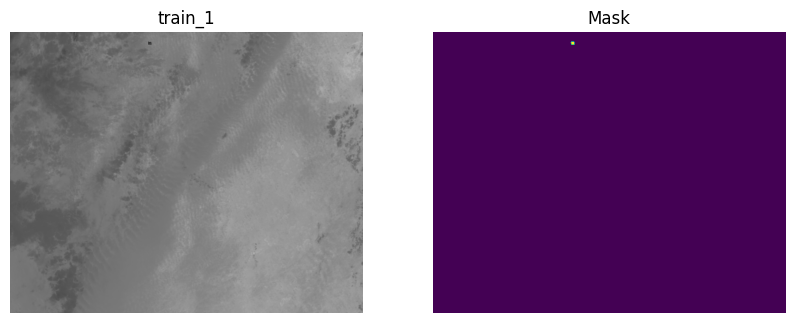

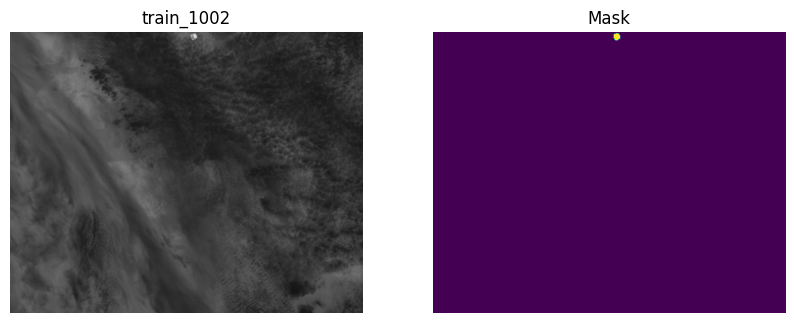

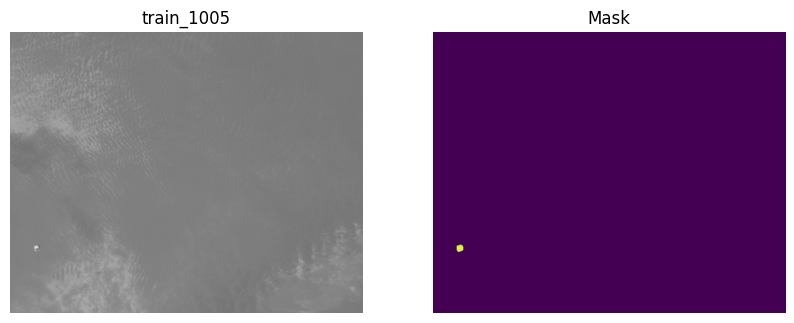

In [266]:
j = 0
for i, size in train_correct_masked_images.items():
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 2, 1)

    plot_image(train_images[i], None, ax, title=f'train_{i}')
    ax = fig.add_subplot(1, 2, 2)
    masks = all_train_masks[size][i]
    possible_masks = find_mask_in_bbox(masks, train_bboxes[i])
    mask = possible_masks[np.argmax([ratio for _, ratio in possible_masks])][0]['segmentation']
    
    plot_image(mask, None, ax, title='Mask')
    plt.show()
    
    j += 1
    if j > 2:
        break

### Create datasets

In [408]:
from datasets import Dataset

# Convert the NumPy arrays to Pillow images and store them in a dictionary
train_dict = {
    "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
    "mask":  [Image.fromarray(mask) for mask in Y_train],
    "bbox":  bbox_train.tolist(),
}
test_dict = {
    "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
    "mask":  [Image.fromarray(mask) for mask in Y_test],
    "bbox":  bbox_test.tolist(),
}

# Create the datasets using the datasets.Dataset class
train_dataset = Dataset.from_dict(train_dict)
test_dataset  = Dataset.from_dict(test_dict)

In [409]:
train_dataset, test_dataset

(Dataset({
     features: ['image', 'mask', 'bbox'],
     num_rows: 513
 }),
 Dataset({
     features: ['image', 'mask', 'bbox'],
     num_rows: 101
 }))

### Get bounding boxes directly from mask

In [211]:
# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

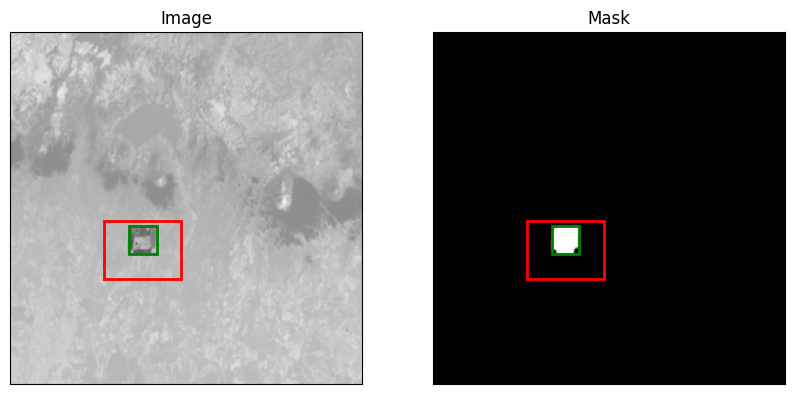

In [435]:
from matplotlib.patches import Rectangle

img_num = random.randint(0, X_train.shape[0]-1)
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["mask"]
example_bbox = train_dataset[img_num]["bbox"]

bbox = get_bounding_box(np.array(example_mask))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the iamge on left
axes[0].imshow(np.array(example_image), cmap='gray')
axes[0].set_title("Image")

# Plot the mask on right
axes[1].imshow(example_mask, cmap='gray')
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    rect_pred = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
    rect_true = Rectangle((example_bbox[0], example_bbox[1]), example_bbox[2], example_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
    
    ax.add_patch(rect_pred)
    ax.add_patch(rect_true)

plt.show()

### Define SAM Dataset Class

In [361]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    Used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        
        ground_truth_mask = np.array(item["mask"])

        # Get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

### Load 'small' (base) model processor, config and model

In [439]:
# Initialize the processor
from transformers import SamModel, SamConfig, SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base")

In [363]:
# Create an instance of the SAMDataset
train_sam_dataset = SAMDataset(dataset=train_dataset, processor=processor)

In [364]:
example = train_sam_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


### Make dataloader

In [365]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_sam_dataset, batch_size=2, shuffle=True, drop_last=False)

In [366]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [319]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load 'small' model

In [593]:
# Load the model
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
# model = SamModel(config=model_config)
# model.load_state_dict(torch.load("sam_checkpoints_finetuned/sam_small_1.pth"))

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder") or name.startswith("image_encoder"):
        param.requires_grad_(False)

### Fine tune

In [589]:
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [590]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch + 1}')
    print(f'\tMean loss: {mean(epoch_losses)}')

  0%|          | 0/257 [00:00<?, ?it/s]


TypeError: Sam.forward() got an unexpected keyword argument 'pixel_values'

### Inference

In [371]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "sam_checkpoints_finetuned/sam_small_1.pth")

In [576]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
model = SamModel(config=model_config)
# Update the model by loading the weights from saved file.
model.load_state_dict(torch.load("sam_checkpoints_finetuned/sam_small_1.pth"))

# Set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [403]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

def predict(model: SamModel, processor: SamProcessor, image: np.ndarray, ground_truth_mask: np.ndarray) -> (np.ndarray, np.ndarray):
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()

    # Perform a forward pass
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)

    # Apply sigmoid
    seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    
    # Convert soft mask to hard mask
    seg_prob = seg_prob.cpu().numpy().squeeze()
    mask = (seg_prob > 0.5).astype(np.uint8)
    
    return mask, seg_prob

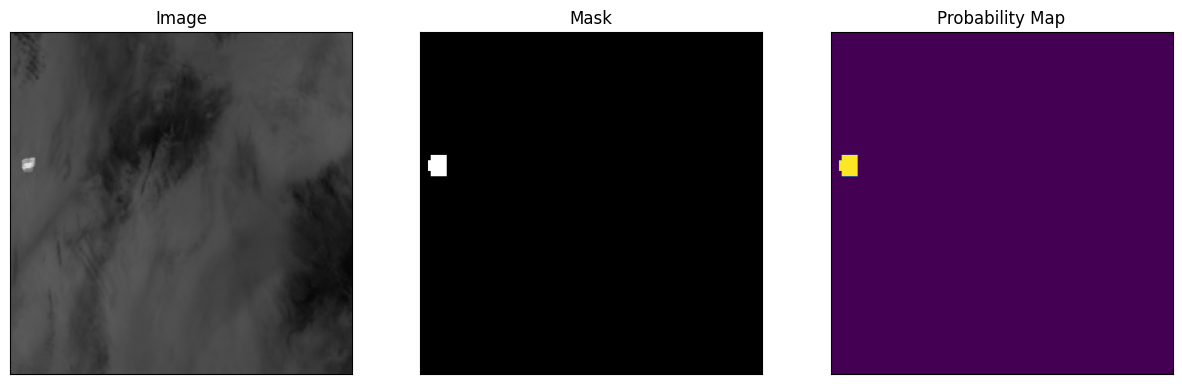

In [577]:
# Get random test data point
idx = random.randint(0, X_test.shape[0]-1)
test_image = test_dataset[idx]["image"]
ground_truth_mask = np.array(test_dataset[idx]["mask"])

# Get mask and probability map
mask, seg_prob = predict(model, processor, test_image, ground_truth_mask)

# Plot image, mask, and probability map
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Image")

axes[1].imshow(mask, cmap='gray')
axes[1].set_title("Mask")

axes[2].imshow(seg_prob)
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.show()


In [578]:
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 1

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [579]:
print(np.array(input_points).shape)

(1, 1, 1, 2)


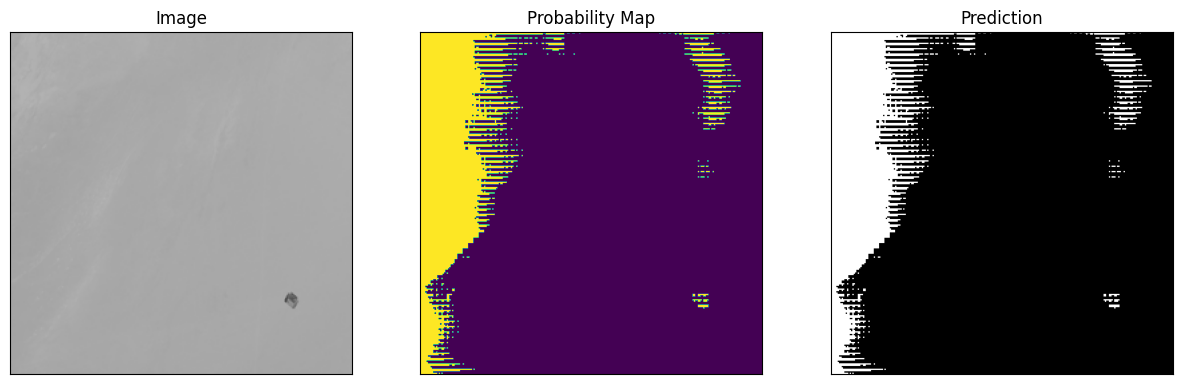

In [585]:
idx = random.randint(0, X_test.shape[0]-1)
test_image = test_dataset[idx]["image"]

inputs = processor(test_image, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()